# Obligatorisk innlevering 2 - oppgave 2

I denne oppgaven skal vi forsøke å forutsi oppsigelser ved en arbeidsplass basert på en rekke variabler som f.eks alder, kjønn, utdannelse, lønn, osv.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn import metrics

In [3]:
# I denne oppgaven skal dere bruke følgende datasett:
df = pd.read_csv("./datasett2.csv")

### Preprosessering:
For å forenkle håndteringen av kategoriske data har jeg her skrevet noe kode som gjør om strenger til intergers

Følgende kolonner er formatert som *object* og inneholder kategoriske variabler i form av strenger

In [4]:
kolonner_obj = df.select_dtypes(include=['object']).columns
print(kolonner_obj)

Index(['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole',
       'MaritalStatus', 'Over18', 'OverTime'],
      dtype='object')


I koden under omformer jeg strengene til integers og gir dere "nøkkelen" til å konvertere det tilbake igjen

In [5]:
for i in kolonner_obj:
    print("-----------")
    print(i)
    print("-----------")
    for num, j in enumerate(list(df[i].unique())):
        print("{} = {}".format(j,num))
        df[i].loc[df[i]==j] = num
    df[i] = pd.to_numeric(df[i])

-----------
BusinessTravel
-----------
Travel_Frequently = 0
Travel_Rarely = 1
Non-Travel = 2
-----------
Department
-----------
Research & Development = 0
Sales = 1
Human Resources = 2
-----------
EducationField
-----------
Medical = 0
Other = 1
Marketing = 2
Life Sciences = 3
Technical Degree = 4
Human Resources = 5
-----------
Gender
-----------
Male = 0
Female = 1
-----------
JobRole
-----------
Laboratory Technician = 0
Sales Representative = 1
Sales Executive = 2
Healthcare Representative = 3
Manager = 4
Manufacturing Director = 5
Research Scientist = 6
Human Resources = 7
Research Director = 8
-----------
MaritalStatus
-----------
Married = 0
Divorced = 1
Single = 2
-----------
Over18
-----------
Y = 0
-----------
OverTime
-----------
Yes = 0
No = 1


/var/folders/lp/hvrbjjbj72g9jyxfscjxts5r0000gn/T/ipykernel_38339/3482823818.py:7: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df[i].loc[df[i]==j] = num
/var/folders/lp/hvrbjjbj72g9jyxfscjxts5r0000gn/T/ipykernel_38339/3482823818.py:7: Setti

I outputen fra koden nedenfor viser datatypen til de forskjellige kolonnene, som nå etter preprosesseringen bare består av integers (int64). 

In [6]:
print(df.dtypes)

id                          int64
Age                         int64
BusinessTravel              int64
DailyRate                   int64
Department                  int64
DistanceFromHome            int64
Education                   int64
EducationField              int64
EmployeeCount               int64
EnvironmentSatisfaction     int64
Gender                      int64
HourlyRate                  int64
JobInvolvement              int64
JobLevel                    int64
JobRole                     int64
JobSatisfaction             int64
MaritalStatus               int64
MonthlyIncome               int64
MonthlyRate                 int64
NumCompaniesWorked          int64
Over18                      int64
OverTime                    int64
PercentSalaryHike           int64
PerformanceRating           int64
RelationshipSatisfaction    int64
StandardHours               int64
StockOptionLevel            int64
TotalWorkingYears           int64
TrainingTimesLastYear       int64
WorkLifeBalanc

In [7]:
# Her deler jeg datasettet inn i egenskaper (X) og target (y) (fjerner også den første kolonnen siden det bare er en ID 
# og har dermed ingen prediktiv verdi)

X = df.iloc[:,1:-1]
y = df.iloc[:,-1]

# Tilslutt deler jeg inn i et trening- og et testsett (75%/25%)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=0)

# PS: Ikke endre denne kodecellen!

#### Oppgave 2.1) 
Visualiser $y\_train$ og $y\_val$ i et histogram. Kan du, basert på figuren, se hva slags problem vi skal løse (regresjon/klassifisering)? Begrunn svaret

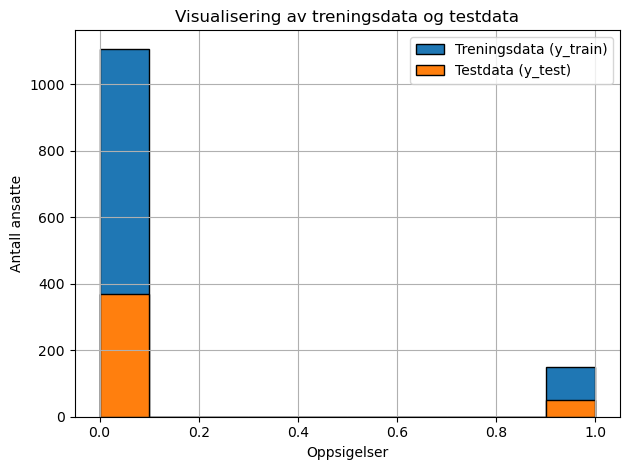

In [8]:
#TODO: visualiser y_train og y_test i et histogram

y_train.hist(edgecolor="black", label="Treningsdata (y_train)")
y_test.hist(edgecolor="black", label="Testdata (y_test)")
plt.ylabel("Antall ansatte")
plt.xlabel("Oppsigelser")
plt.title("Visualisering av treningsdata og testdata")
plt.tight_layout()
plt.legend()
plt.show()

**Svar:**

Basert på kun det man ser i histogrammet er det en klassifiseringsproblem som skal løses.

Grunnen til dette er at stolpene i histogrammet ikke overlapper til andre verdier enn 0 og 1 som gjør dette til et klassifiseringsproblem.

Antagelsen om at dette er en klassifiseringsproblem bevises når man ser på målvariabelen (target) som har diskrete verdier på 0 eller 1.

#### Oppgave 2.2)
Velg to modeller og gjør repeterte kryssvalideringer $(10)$ med $K=5$
* Velg hvorvidt du vil bruke "default" hyperparamtre for modellene eller om du vil gjøre et hyperparametersøk
* Skår ytelsen til modellene ved hjelp av F1-score og accuracy
* Visualiser F1-skårene fra de repeterte kryssvalideringene som et boksplot
* Undersøk om modell 1 er bedre eller dårligere enn modell 2 ved å gjøre en to-sidig T-test på F1-skårene fra de repeterte kryssvalideringene 
* Tolk resultatene skriftlig til slutt 


/Users/patrykokupski/anaconda3/envs/Data_Mining_oblig2/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/patrykokupski/anaconda3/envs/Data_Mining_oblig2/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https

Ytelsen til modellene
Gjennomsnittlig F1-score for logistisk regresjon: 0.01823959204222362
Gjennomsnittlig F1-score for decision tree: 0.28228428396879296
Gjennomsnittlig accuracy for logistisk regresjon: 0.8790017706949979
Gjennomsnittlig accuracy for decision tree: 0.8174969961424146

Decision Tree er en bedre modell


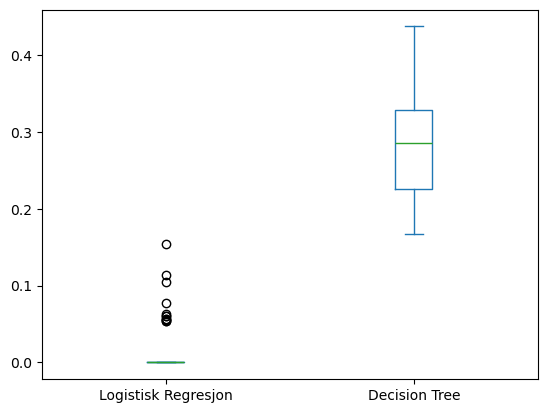

In [9]:
#TODO: repeterte kryssvalideringer for to modeller

#Modellene jeg bruker: Logistisk regresjon og Decision based tree
log_regr_model = LogisticRegression(random_state=42)
decision_tree_model = DecisionTreeClassifier(random_state=42)

#Repeterende kryssvalidering
k_fold = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)

#Skåre ytelsen til modellene: F1-score og accuracy
f1_score_log_regr = cross_val_score(log_regr_model, X_train, y_train, cv=k_fold, scoring="f1")
f1_score_decision_tree = cross_val_score(decision_tree_model, X_train, y_train, cv=k_fold, scoring="f1")
accuracy_log_regr = cross_val_score(log_regr_model, X_train, y_train, cv=k_fold, scoring="accuracy")
accuracy_decision_tree = cross_val_score(decision_tree_model, X_train, y_train, cv=k_fold, scoring="accuracy")

print("Ytelsen til modellene")
print(f"Gjennomsnittlig F1-score for logistisk regresjon: {np.mean(f1_score_log_regr)}")
print(f"Gjennomsnittlig F1-score for decision tree: {np.mean(f1_score_decision_tree)}")
print(f"Gjennomsnittlig accuracy for logistisk regresjon: {np.mean(accuracy_log_regr)}")
print(f"Gjennomsnittlig accuracy for decision tree: {np.mean(accuracy_decision_tree)}")
print()

#Visualisering av F1-score med boksplot
df_f1_score = pd.DataFrame({
    "Logistisk Regresjon": f1_score_log_regr,
    "Decision Tree": f1_score_decision_tree
})
df_f1_score.plot.box()

#Undersøke om Logistisk regresjon eller Decision based tree er bedre vha. to-sidig T-test
_, p_value = stats.ttest_rel(df_f1_score["Logistisk Regresjon"], df_f1_score["Decision Tree"], alternative="two-sided")
if p_value < 0.05:
    if np.mean(f1_score_log_regr) > np.mean(f1_score_decision_tree):
        print("Logistisk regresjon er en bedre modell")
    else:
        print("Decision Tree er en bedre modell")
else:
    print("Ingen signifikant forskjelle mellom modellene")
    

**Svar:**

Tolkning av ytelse basert på F1-score og accuracy:
   - Høyere F1-score med decision tree betyr at den har bedre balanse mellom presisjon og recall (identifiseringsrate av True Postive verdier).
   - Derimot har logistisk regresjon høyere accuracy noe som viser til bedre riktighet for prediksjoner i klassifiseringsprosessen.

Den to-sidig T-test gir oss følgende resultat:
   - Nullhypotesen er usant noe som indikerer at det er signifikant forskjell i F1-score gjennomsnittet mellom modellene.
   - Decision tree har høyere F1-score gjennomsnitt.

Oppsummert:
Logistisk regresjon er bedre på prediksjoner men den har lav F1-score.
Dette sier oss at data er ubalansert (en av klassene er større).
Resultatet er at logistisk regresjon predikterer majoritetsklassen korrekt men ikke minoritetsklassen.
Decision tree sammenlignet med logistisk regresjon har bedre F1-score som viser at den klarer seg bedre på ublansert data.
På grunn av bedre F1-score i dette scenariet er decision tree en bedre modell.

#### Oppgave 2.3) 
Tren de samme modellene men denne gangen med et balansert datasett
* Bruk imbalaced learn og SMOTE til å oppsample minioritetsklassen (bare oppsample treningsdataene i kryssvalideringen - ikke valideringsdataene)
* Skår ytelsen til modellene ved hjelp av F1-score og accuracy
* Visualiser F1-skårene fra de repeterte kryssvalideringene som et boksplot
* Undersøk om modell 1 er bedre eller dårligere enn modell 2 ved å gjøre en to-sidig T-test på F1-skårene fra de repeterte kryssvalideringene 
* Tolk resultatene og sammenlign resultatene med 2.2) 

Counter({0: 1107, 1: 150})
Counter({0: 1107, 1: 1107})


/Users/patrykokupski/anaconda3/envs/Data_Mining_oblig2/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/patrykokupski/anaconda3/envs/Data_Mining_oblig2/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https

Ytelsen til modellene
Gjennomsnittlig F1-score for logistisk regresjon: 0.7544309165137625
Gjennomsnittlig F1-score for decision tree: 0.8825637666757897
Gjennomsnittlig accuracy for logistisk regresjon: 0.7476147819780802
Gjennomsnittlig accuracy for decision tree: 0.8795867338079526

Decision Tree er en bedre modell


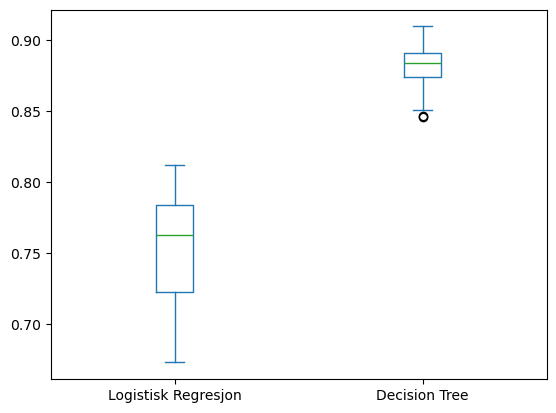

In [10]:
#TODO: repeterte kryssvalideringer for de samme to modellene som i oppgave 2.2, men denne gangen med SMOTE-oppsampling 
#from imblearn.over_sampling import SMOTE

#Original data før SMOTE-oppsampling
print(Counter(y_train))

#SMOTE oppsampling av minioritetsklassen
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)
print(Counter(y_res))

#Modellene jeg bruker: Logistisk regresjon og Decision based tree
log_regr_model = LogisticRegression(random_state=42)
decision_tree_model = DecisionTreeClassifier(random_state=42)

#Repeterende kryssvalidering
k_fold = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)

#Skåre ytelsen til modellene: F1-score og accuracy
f1_score_log_regr = cross_val_score(log_regr_model, X_res, y_res, cv=k_fold, scoring="f1")
f1_score_decision_tree = cross_val_score(decision_tree_model, X_res, y_res, cv=k_fold, scoring="f1")
accuracy_log_regr = cross_val_score(log_regr_model, X_res, y_res, cv=k_fold, scoring="accuracy")
accuracy_decision_tree = cross_val_score(decision_tree_model, X_res, y_res, cv=k_fold, scoring="accuracy")

print("Ytelsen til modellene")
print(f"Gjennomsnittlig F1-score for logistisk regresjon: {np.mean(f1_score_log_regr)}")
print(f"Gjennomsnittlig F1-score for decision tree: {np.mean(f1_score_decision_tree)}")
print(f"Gjennomsnittlig accuracy for logistisk regresjon: {np.mean(accuracy_log_regr)}")
print(f"Gjennomsnittlig accuracy for decision tree: {np.mean(accuracy_decision_tree)}")
print()

#Visualisering av F1-score med boksplot
df_f1_score = pd.DataFrame({
    "Logistisk Regresjon": f1_score_log_regr,
    "Decision Tree": f1_score_decision_tree
})
df_f1_score.plot.box()

#Undersøke om Logistisk regresjon eller Decision based tree er bedre vha. to-sidig T-test
_, p_value = stats.ttest_rel(df_f1_score["Logistisk Regresjon"], df_f1_score["Decision Tree"], alternative="two-sided")
if p_value < 0.05:
    if np.mean(f1_score_log_regr) > np.mean(f1_score_decision_tree):
        print("Logistisk regresjon er en bedre modell")
    else:
        print("Decision Tree er en bedre modell")
else:
    print("Ingen signifikant forskjelle mellom modellene")



**Svar:**

Begge modellene gir bedre resultater i F1-score og accuracy etter oppsamplingen av minioritetsklassen.
Den beste modellen er fortsatt Decision Tree.

Endringer i resultatene fra 2.3 med 2.2:

    - Logistisk regresjon har mye høyere F1-score men lavere accuracy.
    - Decision tree fikk både økning i F1-score og accuracy.

Man kan merke seg at logistisk regresjon har lavere accuracy på balansert data enn ubalansert data.

#### Oppgave 2.4)
Tren den beste modellen på nytt og utfør prediksjon på testsettet. Mål nå ytelsen på testsettet ved bruk av sensitivitet, spesifisitet og presisjon, itillegg til F1-skår og accuracy

In [11]:
#TODO: Tren den beste modellen fra 2.2 og 2.3 på alle treningsdataene og test på testdataene

#Trene modellen og utføre prediksjon på testsettet
decision_tree_model = DecisionTreeClassifier(random_state=42)
decision_tree_model = decision_tree_model.fit(X_res, y_res)
y_predict = decision_tree_model.predict(X_test)

#Bygge opp confusion matrix for å beregne spesifisitet
cm = metrics.confusion_matrix(y_test, y_predict)
specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])

#Måling av modellens ytelse
print("Ytelse til den beste modellen - Decision Tree")
print("Sensitivitet (recall):", metrics.recall_score(y_test, y_predict))
print("Spesifisitet:", specificity)
print("Presisjon:", metrics.precision_score(y_test, y_predict))
print("F1-score:", metrics.f1_score(y_test, y_predict))



Ytelse til den beste modellen - Decision Tree
Sensitivitet (recall): 0.46
Spesifisitet: 0.8378378378378378
Presisjon: 0.27710843373493976
F1-score: 0.3458646616541353


#### Oppgave 2.5)
Del opp testsettet basert på kjønn og gjør en analyse av sensitivitet, spesifisitet og presisjon for menn og det samme for kvinner. Skriv ut og diskuter resultatet og forsøk å svar på følgende spørsmål:
* Er modellen like god for begge kjønn? 
* Hvis ikke, hva tror du er årsaken og hvilke tiltak kan vi gjøre for å forbedre modellen? 

In [12]:
#TODO: Gjør kjønnsbasert analyse på testdataene

#Deler opp testsettet basert på kjønn
X_test_male = X_test[X_test["Gender"] == 0]
X_test_female = X_test[X_test["Gender"] == 1]
y_test_male = y_test[X_test["Gender"] == 0]
y_test_female = y_test[X_test["Gender"] == 1]

#Trene modellen og utføre prediksjon på det kjønnsbaserte testsettet
decision_tree_model = DecisionTreeClassifier(random_state=42)
decision_tree_model = decision_tree_model.fit(X_res, y_res)
y_predict_male = decision_tree_model.predict(X_test_male)
y_predict_female = decision_tree_model.predict(X_test_female)

#Bygge opp confusion matrix for å beregne spesifisitet for menn
cm = metrics.confusion_matrix(y_test_male, y_predict_male)
specificity_male = cm[0, 0] / (cm[0, 0] + cm[0, 1])

#Bygge opp confusion matrix for å beregne spesifisitet for kvinner
cm = metrics.confusion_matrix(y_test_female, y_predict_female)
specificity_female = cm[0, 0] / (cm[0, 0] + cm[0, 1])

#Måling av sensitivitet, spesifisitet og presisjon
print("Ytelse til modellen med testsettet som inneholder kun menn")
print("Sensitivitet (recall):", metrics.recall_score(y_test_male, y_predict_male))
print("Spesifisitet:", specificity_male)
print("Presisjon:", metrics.precision_score(y_test_male, y_predict_male))

print()

print("Ytelse til modellen med testsettet som inneholder kun kvinner")
print("Sensitivitet (recall):", metrics.recall_score(y_test_female, y_predict_female))
print("Spesifisitet:", specificity_female)
print("Presisjon:", metrics.precision_score(y_test_female, y_predict_female))

Ytelse til modellen med testsettet som inneholder kun menn
Sensitivitet (recall): 0.4722222222222222
Spesifisitet: 0.8433179723502304
Presisjon: 0.3333333333333333

Ytelse til modellen med testsettet som inneholder kun kvinner
Sensitivitet (recall): 0.42857142857142855
Spesifisitet: 0.8300653594771242
Presisjon: 0.1875


**Svar:**

Resultatet viser at modellen har bedre ytelse med testsettet som inneholder kun menn.
Spesielt gjelder det presisjon.

Mulig årsak til dårligere ytelse på testsettet med kun kvinner:
-   Det er flere menn enn kvinner opprinelig i testsettet.

Mulige tiltak for å forbedre modellen:
-   Bruke oppsampling med SMOTE som i 2.3 for å balansere testsettet før oppdeling i menn og kvinner.
-   Bruke modell som håndterer ubalanserte data på en bedre måte.



Kjør denne cellen til slutt og legg ved den genererte requirements.txt fila i pull requestet

In [13]:
!pip freeze > requirements.txt